# Data creation with minimal exploration


In [1]:
#audio
from __future__ import print_function
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import librosa
import librosa.display

In [2]:
import pandas as pd 
import pyloudnorm as pyln

In [3]:
#video
import moviepy
from moviepy.editor import *

In [4]:
#importing audio
#x1 waveform 
#fs sampling rate

In [5]:
file_dir_list=["Mistborn E0 - Scott.wav", "Mistborn E0 - Zack.wav"]



In [6]:
AUDIO_VIDEO_TUPLE_LIST=[("Mistborn E0 - Scott.wav", 1), ("Mistborn E0 - Zack.wav",2)]

In [7]:
VIDEO_FILEPATH_LIST= ["Middle View.mp4","Scott View.mp4","Zack View.mp4"]

## Creating Data for each Microphone


In [8]:
#importing video and its audio
def dataframecreation(file_dir_list,rate):
    df_list=[]
    instance=1
    for file_dir in file_dir_list:
        data1, rate1 = librosa.load(file_dir, sr=48000) 
        data= librosa.resample(data1, orig_sr=rate1, target_sr=rate, scale=True)

        # peak normalize audio to -1 dB
        peak_normalized_audio = pyln.normalize.peak(data, -1.0)

        # measure the loudness first 
        meter = pyln.Meter(rate) # create BS.1770 meter
        loudness = meter.integrated_loudness(data)

        # loudness normalize audio to -12 dB LUFS
        audio_data_df = pd.DataFrame(pyln.normalize.loudness(data, loudness, -20.0)).rename(columns={0:str(instance)})
        df_list.append(audio_data_df)
        instance=instance+1
    return(df_list)

In [9]:
def doublerollingaverage1(df_list,rate):
    dra_df_list=[]
    for df in df_list:
        indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=2*rate)
        rollingaverage_df=df.abs().rolling(indexer).mean()
        Drollingaverage_df=rollingaverage_df.abs().rolling(rate*5,center=True).mean()
        dra_df_list.append(Drollingaverage_df)
    return dra_df_list

In [10]:
def doublerollingaverage(df_list,rate):
    dra_df_list=[]
    for df in df_list:
        rollingaverage_df=df.abs().rolling(rate*5,center=True).mean()
        Drollingaverage_df=rollingaverage_df.abs().rolling(rate*5,center=True).mean()
        dra_df_list.append(Drollingaverage_df)
    return dra_df_list

# Exhibit A: blue laughs while orange is talking. at 2:02. Speaker shifts at around 2:30.5 and 2:53

In [11]:
rate=500 #samples per sec

In [12]:
df_list=dataframecreation(file_dir_list,rate)


In [13]:
dra_df_list=doublerollingaverage(df_list,rate)

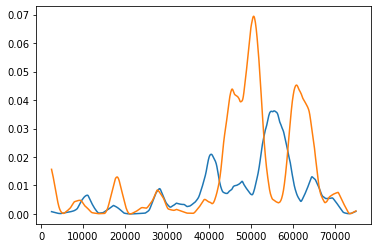

Executing shutdown due to inactivity...


2022-07-08 23:24:25,768 - INFO     - Executing shutdown due to inactivity...


Executing shutdown...


2022-07-08 23:24:25,778 - INFO     - Executing shutdown...


Exception on /shutdown [GET]
Traceback (most recent call last):
  File "/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/flask/app.py", line 2077, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/flask/app.py", line 1525, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/flask/app.py", line 1523, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/flask/app.py", line 1509, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/dtale/app.py", line 410, in shutdown
    shutdown_server()
  File "/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/dtale/app.py", line 396, in shutdown_server
    raise RuntimeE

2022-07-08 23:24:25,779 - ERROR    - Exception on /shutdown [GET]
Traceback (most recent call last):
  File "/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/flask/app.py", line 2077, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/flask/app.py", line 1525, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/flask/app.py", line 1523, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/flask/app.py", line 1509, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/dtale/app.py", line 410, in shutdown
    shutdown_server()
  File "/home/jeffwa/anaconda3/envs/DL_new/lib/python3.10/site-packages/dtale/app.py", line 396, 

In [35]:
fig = plt.figure()
for frame in dra_df_list:
    plt.plot(frame[0:150*rate])



# Testing the logics, Creating speaking intervals

In [15]:
import dtale

In [16]:
#combine dfs first
combined_df=pd.concat(dra_df_list,axis=1)
#this why sync is important so that the rows are exactly aligned

In [17]:
range(len(combined_df.loc[10000].values))

range(0, 2)

In [18]:
#create list of string to call for each audio file. Used to call the audio name
list_str_audio_thresholds=[]

#for each audio element, create a new list "A{i}" and put that into a list
#each audio file is identified by its place in the tuple
for irow in range(len(AUDIO_VIDEO_TUPLE_LIST)):
    varname="A"
    exec(f"{varname}{irow} = []")
    
    
    list_str_audio_thresholds.append(varname+str(irow))

In [19]:
eval(list_str_audio_thresholds[1])

[]

# testing

In [20]:
frames_list=[]
largestindex_list=[]
crossover_list=[]
high_multiplethreshold_list=[]
similarloudness_list=[]
low_multiplethreshold_list=[]
for irow in range(len(combined_df)):
    #creating variables to call

    #more efficient to call variable than constant function calling
    nlargest=combined_df.loc[irow].nlargest(2)
    idxmax=combined_df.loc[irow].idxmax()
    values=combined_df.loc[irow].values
    if irow !=0:
        prev_idxmax=combined_df.loc[irow-1].idxmax()
    
    if pd.notna(combined_df.loc[irow].idxmax())==True:
        
        #largest value index
        frames_list.append(int(idxmax))
        
        #indicators
        
        #crossover
        if combined_df.loc[irow].idxmax() != combined_df.loc[irow-1].idxmax():
            crossover_list.append(1)
        else:
            crossover_list.append(0)
            
            
        # multiple above threshold .035
        if nlargest[1]> .035:
            high_multiplethreshold_list.append(1)
        else:
            high_multiplethreshold_list.append(0)

        #all below threshold .035
        if nlargest[0]< .035:
            low_multiplethreshold_list.append(1)
        else:
            low_multiplethreshold_list.append(0)
        
        #similar loudness
        if nlargest[0]-nlargest[1] <.007:
            similarloudness_list.append(1)
        else:
            similarloudness_list.append(0)
            
#=======audio threshold  ===================================================================  
        for ix in range(len(values)):
            if values[ix]>.015 :
                eval(list_str_audio_thresholds[ix]).append(1)

            else:
                eval(list_str_audio_thresholds[ix]).append(0)
    else:
        frames_list.append(0)
        crossover_list.append(0)
        high_multiplethreshold_list.append(0)
        similarloudness_list.append(0)
        low_multiplethreshold_list.append(0)
        
        for ix in range(len(values)):
            if values[ix]>.007 :
                eval(list_str_audio_thresholds[ix]).append(1)

            else:
                eval(list_str_audio_thresholds[ix]).append(0)
#if there is another crossover within  6 secs after crossover, maintain center cam 

 


In [21]:
len(eval(list_str_audio_thresholds[0]))/len(high_multiplethreshold_list)

1.0

In [22]:
test=pd.DataFrame({"idxmax":frames_list,"crossover":crossover_list,"high_mult_thresh":high_multiplethreshold_list,"low_mult_thresh":low_multiplethreshold_list,"nearnesssound":similarloudness_list})

In [23]:
#add collumn for each element in a list and use its corresponding list variable
for i in range(len(list_str_audio_thresholds)):
    test[list_str_audio_thresholds[i]]=eval(list_str_audio_thresholds[i])

In [24]:
test

,idxmax,crossover,high_mult_thresh,low_mult_thresh,nearnesssound,A0,A1
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
551995,0,0,0,0,0,0,0
551996,0,0,0,0,0,0,0
551997,0,0,0,0,0,0,0
551998,0,0,0,0,0,0,0


In [25]:
test['cam_view']= test['idxmax'].apply(lambda row: AUDIO_VIDEO_TUPLE_LIST[row-1][1] if row!=0 else 0)

In [26]:
test.to_pickle("idxmax.pkl")

In [27]:
dtale.show(test)

## Crossover list

In [28]:
test['crossover'].index[test['crossover']==1].to_series()

2500        2500
5190        5190
5605        5605
9614        9614
15664      15664
27840      27840
42476      42476
53072      53072
58760      58760
66315      66315
68470      68470
73564      73564
74072      74072
93570      93570
97040      97040
111361    111361
119096    119096
120543    120543
125109    125109
132395    132395
133271    133271
144056    144056
145753    145753
161729    161729
164917    164917
166442    166442
172214    172214
177497    177497
180223    180223
195598    195598
202492    202492
218448    218448
230734    230734
267665    267665
272480    272480
277063    277063
279765    279765
302150    302150
326089    326089
336072    336072
341419    341419
355431    355431
356663    356663
363228    363228
375951    375951
418188    418188
426541    426541
442671    442671
457639    457639
459596    459596
466172    466172
477492    477492
483218    483218
494554    494554
502812    502812
519549    519549
527213    527213
536170    536170
538636    5386

In [29]:
def dataframe_getintervals(series,desiredvalue):
    #make sure series is the df['column']
    t=series.index[series==desiredvalue].to_series()
    interval_list=t.groupby(t.diff().ne(1).cumsum()).agg(['first','last']).apply(tuple,1).tolist()
    
    return interval_list

In [30]:
t=test['nearnesssound'].index[test['nearnesssound']==1].to_series()

In [31]:
intervallist=t.groupby(t.diff().ne(1).cumsum()).agg(['first','last']).apply(tuple,1).tolist()

In [32]:
intervallist_near=dataframe_getintervals(test['nearnesssound'],1)

In [33]:
intervallist_mult=dataframe_getintervals(test['mult_thresh'],1)

KeyError: 'mult_thresh'

In [ ]:
too_short=0
too_near=0
for i in range(len(intervallist_mult)):
    value=intervallist[i][1]+rate*3
    
    if intervallist[i][0]+2*rate > intervallist[i][1]:
        too_short=too_short+1
    if i==len(intervallist)-1:
        pass
    
    else: 
        if value > intervallist[i+1][0]:
            too_near=too_near+1

In [ ]:
too_near

In [ ]:
too_short

In [ ]:
i

In [ ]:
intervallist[0][0]+rate < intervallist[0][1]

In [ ]:
intervallist[0][1]

## Testing pandas intervalindex

## Setup Logic 1: Safe, crossover, threshold and nearness

In [ ]:
#Priority from least to greatest 
#highest priority set last to override



#1 current loudest: set the current loudest as the camera, sets the skeletal outline of the default timeline
#the only loop 
outline=test['idxmax']


#2 nearness with no crossover nearby next one second (not implemented for now)
#if nearness, check if near crossover within 3 seconds, if no crossover, set camera to default for interval+1 second ahead. 
#outline2=outline


#3 multiple with threshold
#Where there are multiple mics above threshold, set camera to default for interval and 1 second ahead. 




#4 crossover gives 3 seconds
#see all crossovers, add three seconds of default cam



#if crossovers occur, play center cam for three seconds and then maintain loudest speaker


    #if there is a second speaker near the same loudness BUT A CROSSOVER DOES NOT OCCUR IN THE NEXT 3 Secs
    #change to center cam for 3 seconds 



## Seeing Logic differences speaker and listener transition

## Creating the XML file

In [ ]:
nlargest